In [65]:
import pandas

from datetime import datetime, timedelta
from matplotlib import pyplot

In [88]:
df = pandas.read_csv("cpu_bound_1.csv")
df.columns

Index(['measurementID', 'version', 'lang', 'startTime', 'uuid', 'newcontainer',
       'vmuptime', 'platform', 'containerID', 'functionName', 'functionMemory',
       'functionRegion', 'vmID', 'linuxVersion', 'totalMemory', 'freeMemory',
       'pageFaults', 'cpuType', 'cpuModel', 'cpuUsr', 'cpuNice', 'cpuKrn',
       'cpuIdle', 'cpuIowait', 'cpuIrq', 'cpuSoftIrq', 'vmcpusteal',
       'contextSwitches', 'frameworkRuntime', 'runtime', 'endTime',
       'network_rx_bytes.telemetry1_sb', 'network_rx_bytes.vtarget_1',
       'network_rx_bytes.vinternal_1', 'network_rx_bytes.lo'],
      dtype='object')

In [89]:
start_timestamp = df["startTime"].min() / 1000
end_timestamp = df["endTime"].max() / 1000
start_datetime = datetime.fromtimestamp(start_timestamp)
end_datetime = datetime.fromtimestamp(end_timestamp)

print(start_datetime)
print(end_datetime)
print(f"Total runtime: {round(end_timestamp - start_timestamp, 2)} seconds")

2021-12-10 11:55:41.163000
2021-12-10 11:56:06.888000
Total runtime: 25.72 seconds


Text(0, 0.5, 'Lambda invokation')

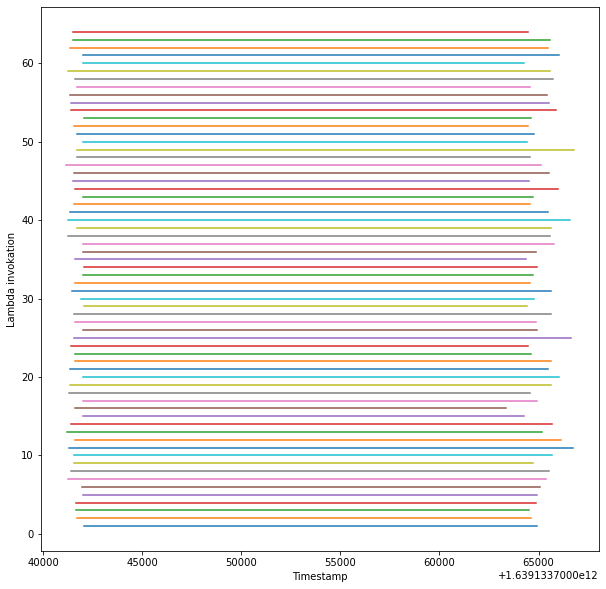

In [68]:
pyplot.figure(figsize=(10,10))
for number, (label, lambdadf) in enumerate(df.groupby("uuid")):
    pyplot.plot(lambdadf.groupby("startTime")["measurementID"].count()+ number)
pyplot.xlabel("Timestamp")
pyplot.ylabel("Lambda invokation")

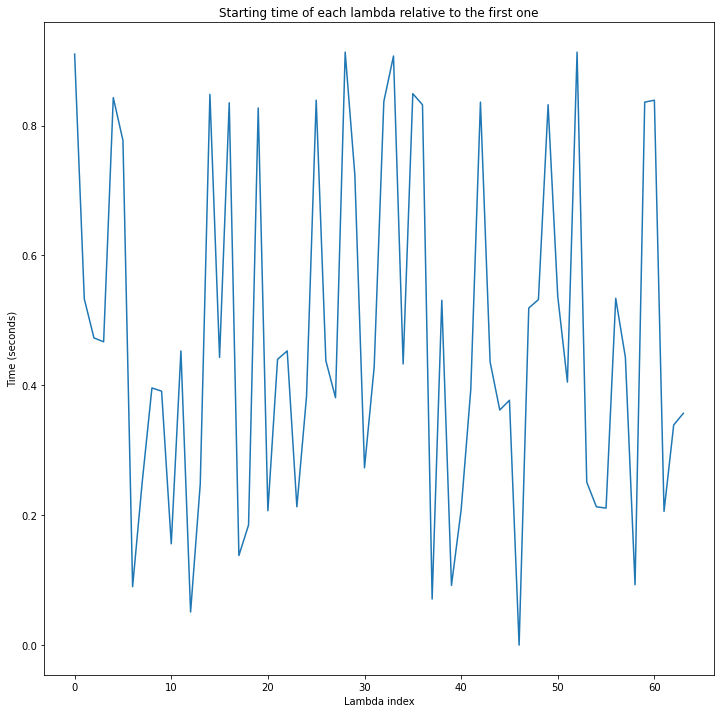

In [69]:
minstartdf = df.groupby('uuid')[["startTime"]].min().reset_index()
minstartdf["startTime"] = minstartdf["startTime"] / 1000

pyplot.figure(figsize=(12,12))
pyplot.title("Starting time of each lambda relative to the first one")
pyplot.xlabel("Lambda index")
pyplot.ylabel("Time (seconds)")
pyplot.plot(minstartdf.index, minstartdf["startTime"]-minstartdf["startTime"].min())

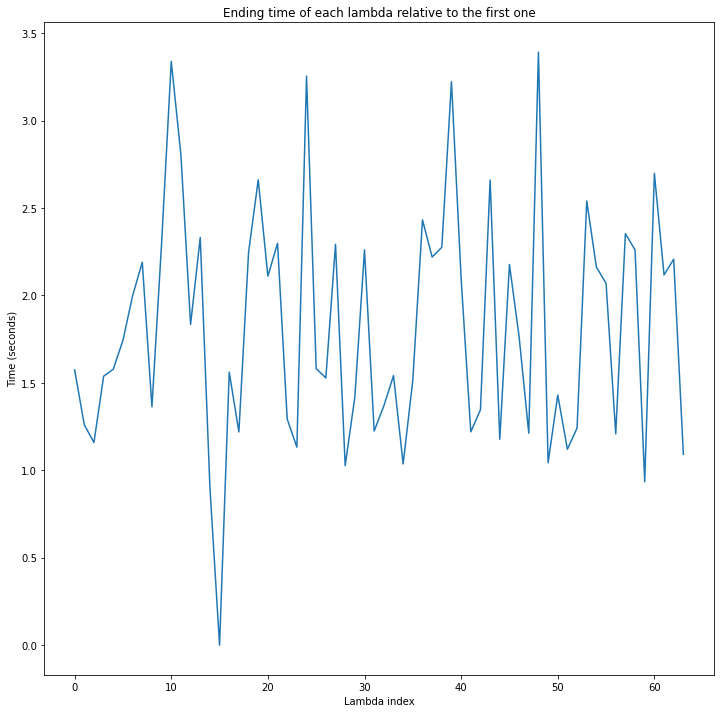

In [70]:
maxenddf = df.groupby('uuid')[["endTime"]].max().reset_index()
maxenddf["endTime"] = maxenddf["endTime"] / 1000

pyplot.figure(figsize=(12,12))
pyplot.title("Ending time of each lambda relative to the first one")
pyplot.xlabel("Lambda index")
pyplot.ylabel("Time (seconds)")
pyplot.plot(maxenddf.index, maxenddf["endTime"]-maxenddf["endTime"].min())

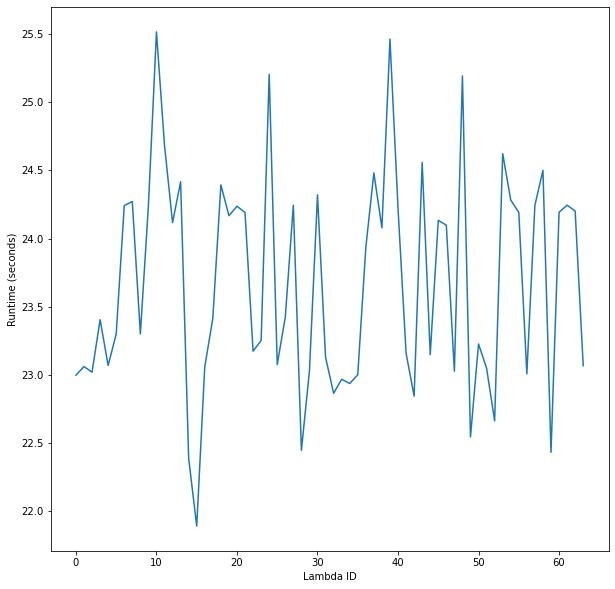

In [71]:
runtimedf = df.groupby('uuid')[["startTime","endTime"]].agg(minstart=("startTime","min"),maxend=("endTime","max")).reset_index()
runtimedf["runtime"] = (runtimedf["maxend"] - runtimedf["minstart"]) / 1000
runtimedf

pyplot.figure(figsize=(10,10))
pyplot.ylabel("Runtime (seconds)")
pyplot.xlabel("Lambda ID")
pyplot.plot(runtimedf.index, runtimedf["runtime"])

In [72]:
cpudf = df[["uuid","startTime","endTime","cpuUsr"]]
cpudf

,uuid,startTime,endTime,cpuUsr
0,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133741163,1639133741300,4801
1,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133742301,1639133742441,4903
2,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133743443,1639133743581,5007
3,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133744584,1639133744718,5113
4,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133745719,1639133745858,5219
...,...,...,...,...
1373,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133760879,1639133761020,6598
1374,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133762022,1639133762161,6700
1375,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133763163,1639133763317,6806
1376,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133764319,1639133764474,6913


In [73]:
dfs = []
for label, curdf in cpudf.groupby('uuid'):
    curdf["cpuPercent"] = curdf.cpuUsr.diff().shift(-1)
    dfs.append(curdf)


cpupercentdf = pandas.concat(dfs).reset_index(drop=True)
cpupercentdf["startDateTime"] = (cpupercentdf["startTime"]/pow(10,3)).apply(datetime.fromtimestamp)
cpupercentdf

,uuid,startTime,endTime,cpuUsr,cpuPercent,startDateTime
0,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133742073,1639133742212,4716,108.0,2021-12-10 11:55:42.073
1,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133743214,1639133743353,4824,109.0,2021-12-10 11:55:43.214
2,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133744355,1639133744509,4933,108.0,2021-12-10 11:55:44.355
3,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133745510,1639133745649,5041,108.0,2021-12-10 11:55:45.510
4,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133746651,1639133746792,5149,109.0,2021-12-10 11:55:46.651
...,...,...,...,...,...,...
1373,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133759885,1639133760029,6545,107.0,2021-12-10 11:55:59.885
1374,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133761031,1639133761166,6652,107.0,2021-12-10 11:56:01.031
1375,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133762167,1639133762306,6759,108.0,2021-12-10 11:56:02.167
1376,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133763307,1639133763444,6867,108.0,2021-12-10 11:56:03.307


In [74]:
metrics = df[["uuid","startTime","cpuUsr","network_rx_bytes.vinternal_1"]].copy()
metrics

,uuid,startTime,cpuUsr,network_rx_bytes.vinternal_1
0,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133741163,4801,9786
1,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133742301,4903,9786
2,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133743443,5007,9786
3,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133744584,5113,9786
4,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133745719,5219,9786
...,...,...,...,...
1373,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133760879,6598,9928
1374,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133762022,6700,9928
1375,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133763163,6806,9928
1376,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133764319,6913,9928


In [75]:
metrics["startDateTime"] = (metrics["startTime"]/pow(10,3)).apply(datetime.fromtimestamp)
metrics

,uuid,startTime,cpuUsr,network_rx_bytes.vinternal_1,startDateTime
0,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133741163,4801,9786,2021-12-10 11:55:41.163
1,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133742301,4903,9786,2021-12-10 11:55:42.301
2,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133743443,5007,9786,2021-12-10 11:55:43.443
3,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133744584,5113,9786,2021-12-10 11:55:44.584
4,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133745719,5219,9786,2021-12-10 11:55:45.719
...,...,...,...,...,...
1373,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133760879,6598,9928,2021-12-10 11:56:00.879
1374,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133762022,6700,9928,2021-12-10 11:56:02.022
1375,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133763163,6806,9928,2021-12-10 11:56:03.163
1376,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133764319,6913,9928,2021-12-10 11:56:04.319


In [76]:
def round_seconds(obj: datetime, how="previous") -> datetime:
    if how=="previous":
        obj -= timedelta(seconds=1)
    else:
        obj += timedelta(seconds=1)
    return obj.replace(microsecond=0)

timebins = []
current_datetime = round_seconds(start_datetime)
while current_datetime <= end_datetime:
    timebins.append(current_datetime)
    current_datetime += timedelta(seconds=2)
timebins.append(round_seconds(end_datetime, how="next"))
timebins

[datetime.datetime(2021, 12, 10, 11, 55, 40),
 datetime.datetime(2021, 12, 10, 11, 55, 42),
 datetime.datetime(2021, 12, 10, 11, 55, 44),
 datetime.datetime(2021, 12, 10, 11, 55, 46),
 datetime.datetime(2021, 12, 10, 11, 55, 48),
 datetime.datetime(2021, 12, 10, 11, 55, 50),
 datetime.datetime(2021, 12, 10, 11, 55, 52),
 datetime.datetime(2021, 12, 10, 11, 55, 54),
 datetime.datetime(2021, 12, 10, 11, 55, 56),
 datetime.datetime(2021, 12, 10, 11, 55, 58),
 datetime.datetime(2021, 12, 10, 11, 56),
 datetime.datetime(2021, 12, 10, 11, 56, 2),
 datetime.datetime(2021, 12, 10, 11, 56, 4),
 datetime.datetime(2021, 12, 10, 11, 56, 6),
 datetime.datetime(2021, 12, 10, 11, 56, 7)]

In [77]:
metrics["bins"] = pandas.cut(metrics["startDateTime"], timebins)
metrics

,uuid,startTime,cpuUsr,network_rx_bytes.vinternal_1,startDateTime,bins
0,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133741163,4801,9786,2021-12-10 11:55:41.163,"(2021-12-10 11:55:40, 2021-12-10 11:55:42]"
1,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133742301,4903,9786,2021-12-10 11:55:42.301,"(2021-12-10 11:55:42, 2021-12-10 11:55:44]"
2,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133743443,5007,9786,2021-12-10 11:55:43.443,"(2021-12-10 11:55:42, 2021-12-10 11:55:44]"
3,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133744584,5113,9786,2021-12-10 11:55:44.584,"(2021-12-10 11:55:44, 2021-12-10 11:55:46]"
4,b5b864ab-ef04-44b0-8286-d590f1cdd6aa,1639133745719,5219,9786,2021-12-10 11:55:45.719,"(2021-12-10 11:55:44, 2021-12-10 11:55:46]"
...,...,...,...,...,...,...
1373,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133760879,6598,9928,2021-12-10 11:56:00.879,"(2021-12-10 11:56:00, 2021-12-10 11:56:02]"
1374,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133762022,6700,9928,2021-12-10 11:56:02.022,"(2021-12-10 11:56:02, 2021-12-10 11:56:04]"
1375,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133763163,6806,9928,2021-12-10 11:56:03.163,"(2021-12-10 11:56:02, 2021-12-10 11:56:04]"
1376,efd8016c-4b6b-4fc4-84e9-c0913334fe31,1639133764319,6913,9928,2021-12-10 11:56:04.319,"(2021-12-10 11:56:04, 2021-12-10 11:56:06]"


Text(0, 0.5, 'Lambda invokation')

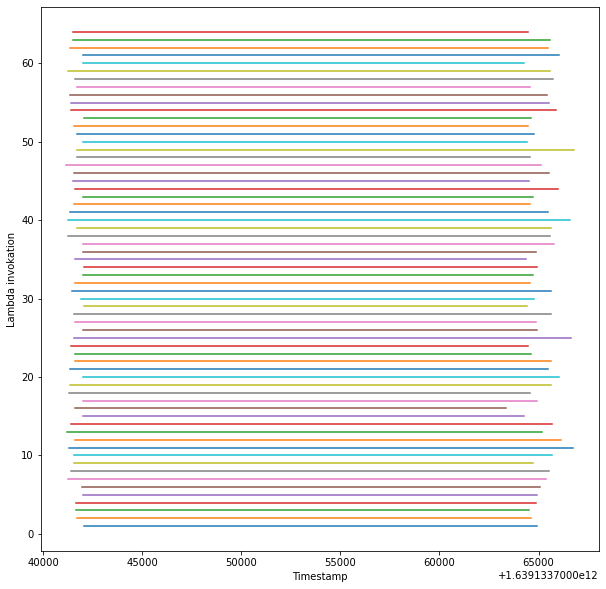

In [78]:
pyplot.figure(figsize=(10,10))
for number, (label, lambdadf) in enumerate(metrics.groupby("uuid")):
    pyplot.plot(lambdadf.groupby("startTime")["cpuUsr"].count() + number)
pyplot.xlabel("Timestamp")
pyplot.ylabel("Lambda invokation")

In [79]:
for value in metrics.loc[0]:
    print(value)

b5b864ab-ef04-44b0-8286-d590f1cdd6aa
1639133741163
4801
9786
2021-12-10 11:55:41.163000
(2021-12-10 11:55:40, 2021-12-10 11:55:42]


In [80]:
for grouplabel, groupdf in metrics.groupby(["bins"]):
    #print(f"Label: {grouplabel}")
    print(f"Entries: {len(groupdf)}")
    #print(f"DataFrame: {groupdf}")
    print(len(groupdf.uuid.unique()))

Entries: 55
55
Entries: 118
64
Entries: 98
64
Entries: 113
64
Entries: 121
64
Entries: 110
64
Entries: 97
64
Entries: 121
64
Entries: 118
64
Entries: 113
64
Entries: 93
64
Entries: 124
64
Entries: 90
63
Entries: 7
7


In [81]:
cpupercentdf["bins"] = pandas.cut(cpupercentdf["startDateTime"], timebins)
cpupercentdf

,uuid,startTime,endTime,cpuUsr,cpuPercent,startDateTime,bins
0,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133742073,1639133742212,4716,108.0,2021-12-10 11:55:42.073,"(2021-12-10 11:55:42, 2021-12-10 11:55:44]"
1,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133743214,1639133743353,4824,109.0,2021-12-10 11:55:43.214,"(2021-12-10 11:55:42, 2021-12-10 11:55:44]"
2,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133744355,1639133744509,4933,108.0,2021-12-10 11:55:44.355,"(2021-12-10 11:55:44, 2021-12-10 11:55:46]"
3,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133745510,1639133745649,5041,108.0,2021-12-10 11:55:45.510,"(2021-12-10 11:55:44, 2021-12-10 11:55:46]"
4,01866d12-395c-42ac-bca3-c7c6fc07dac8,1639133746651,1639133746792,5149,109.0,2021-12-10 11:55:46.651,"(2021-12-10 11:55:46, 2021-12-10 11:55:48]"
...,...,...,...,...,...,...,...
1373,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133759885,1639133760029,6545,107.0,2021-12-10 11:55:59.885,"(2021-12-10 11:55:58, 2021-12-10 11:56:00]"
1374,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133761031,1639133761166,6652,107.0,2021-12-10 11:56:01.031,"(2021-12-10 11:56:00, 2021-12-10 11:56:02]"
1375,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133762167,1639133762306,6759,108.0,2021-12-10 11:56:02.167,"(2021-12-10 11:56:02, 2021-12-10 11:56:04]"
1376,f47c73e7-c61a-4a4f-808d-729f73b7740e,1639133763307,1639133763444,6867,108.0,2021-12-10 11:56:03.307,"(2021-12-10 11:56:02, 2021-12-10 11:56:04]"


In [82]:
for grouplabel, groupdf in cpupercentdf.groupby(["bins"]):
    #print(f"Label: {grouplabel}")
    print(f"Entries: {len(groupdf)}")
    #print(f"DataFrame: {groupdf}")
    print(len(groupdf.uuid.unique()))

Entries: 55
55
Entries: 118
64
Entries: 98
64
Entries: 113
64
Entries: 121
64
Entries: 110
64
Entries: 97
64
Entries: 121
64
Entries: 118
64
Entries: 113
64
Entries: 93
64
Entries: 124
64
Entries: 90
63
Entries: 7
7


In [83]:
def f(series):
    return len(series.unique())
cpusumdf = metrics.groupby("bins").agg(cpu_sum=("cpuUsr","sum"), numlambdas=("uuid",f)).reset_index()
cpusumdf

,bins,cpu_sum,numlambdas
0,"(2021-12-10 11:55:40, 2021-12-10 11:55:42]",262346,55
1,"(2021-12-10 11:55:42, 2021-12-10 11:55:44]",577719,64
2,"(2021-12-10 11:55:44, 2021-12-10 11:55:46]",496469,64
3,"(2021-12-10 11:55:46, 2021-12-10 11:55:48]",591357,64
4,"(2021-12-10 11:55:48, 2021-12-10 11:55:50]",658420,64
5,"(2021-12-10 11:55:50, 2021-12-10 11:55:52]",619920,64
6,"(2021-12-10 11:55:52, 2021-12-10 11:55:54]",561629,64
7,"(2021-12-10 11:55:54, 2021-12-10 11:55:56]",723118,64
8,"(2021-12-10 11:55:56, 2021-12-10 11:55:58]",729157,64
9,"(2021-12-10 11:55:58, 2021-12-10 11:56:00]",719632,64


In [84]:
cpusumdfpercent = cpupercentdf.groupby("bins").agg(cpu_sum=("cpuPercent","sum"), numlambdas=("uuid",f)).reset_index()
cpusumdfpercent

,bins,cpu_sum,numlambdas
0,"(2021-12-10 11:55:40, 2021-12-10 11:55:42]",5749.0,55
1,"(2021-12-10 11:55:42, 2021-12-10 11:55:44]",12459.0,64
2,"(2021-12-10 11:55:44, 2021-12-10 11:55:46]",10334.0,64
3,"(2021-12-10 11:55:46, 2021-12-10 11:55:48]",11967.0,64
4,"(2021-12-10 11:55:48, 2021-12-10 11:55:50]",12773.0,64
5,"(2021-12-10 11:55:50, 2021-12-10 11:55:52]",11652.0,64
6,"(2021-12-10 11:55:52, 2021-12-10 11:55:54]",10235.0,64
7,"(2021-12-10 11:55:54, 2021-12-10 11:55:56]",12794.0,64
8,"(2021-12-10 11:55:56, 2021-12-10 11:55:58]",12441.0,64
9,"(2021-12-10 11:55:58, 2021-12-10 11:56:00]",11895.0,64


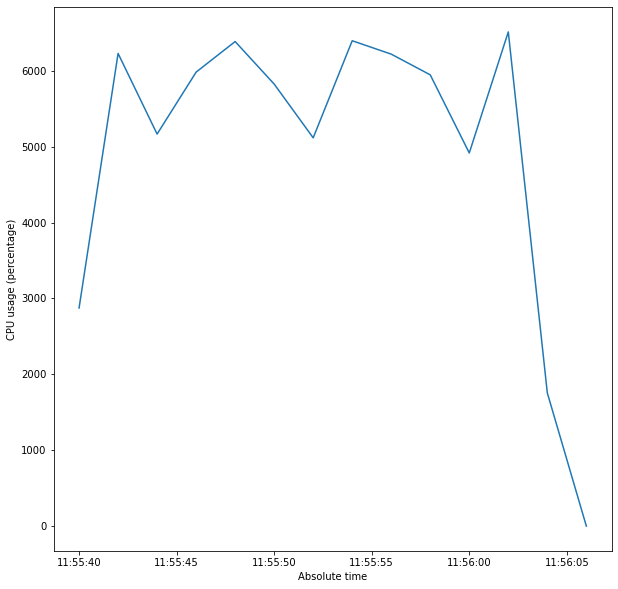

In [85]:
fig, ax = pyplot.subplots(figsize=(10,10))
pyplot.plot(cpusumdfpercent["bins"].apply(lambda x: x.left), cpusumdfpercent["cpu_sum"]/2, label="CPU Usage")
pyplot.xlabel("Absolute time")
pyplot.ylabel("CPU usage (percentage)")
fig.savefig('cpuusage_cpubound.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

In [86]:
cpusumdfpercent["bins"].apply(lambda x: x.left)

0    2021-12-10 11:55:40
1    2021-12-10 11:55:42
2    2021-12-10 11:55:44
3    2021-12-10 11:55:46
4    2021-12-10 11:55:48
5    2021-12-10 11:55:50
6    2021-12-10 11:55:52
7    2021-12-10 11:55:54
8    2021-12-10 11:55:56
9    2021-12-10 11:55:58
10   2021-12-10 11:56:00
11   2021-12-10 11:56:02
12   2021-12-10 11:56:04
13   2021-12-10 11:56:06
Name: bins, dtype: category
Categories (14, datetime64[ns]): [2021-12-10 11:55:40 < 2021-12-10 11:55:42 < 2021-12-10 11:55:44 < 2021-12-10 11:55:46 ... 2021-12-10 11:56:00 < 2021-12-10 11:56:02 < 2021-12-10 11:56:04 < 2021-12-10 11:56:06]

In [57]:
networksumdf = metrics.groupby("bins").agg(network_sum=("network_rx_bytes.vinternal_1","sum"), numlambdas=("uuid",f)).reset_index()
networksumdf

,bins,network_sum,numlambdas
0,"(2021-12-10 12:00:17, 2021-12-10 12:00:19]",498526,34
1,"(2021-12-10 12:00:19, 2021-12-10 12:00:21]",1406464,64
2,"(2021-12-10 12:00:21, 2021-12-10 12:00:23]",1816918,64
3,"(2021-12-10 12:00:23, 2021-12-10 12:00:25]",1553642,64
4,"(2021-12-10 12:00:25, 2021-12-10 12:00:27]",1494492,64
5,"(2021-12-10 12:00:27, 2021-12-10 12:00:29]",1655666,64
6,"(2021-12-10 12:00:29, 2021-12-10 12:00:31]",1773286,64
7,"(2021-12-10 12:00:31, 2021-12-10 12:00:33]",1494292,64
8,"(2021-12-10 12:00:33, 2021-12-10 12:00:35]",1538696,64
9,"(2021-12-10 12:00:35, 2021-12-10 12:00:37]",1670562,64


<AxesSubplot:>

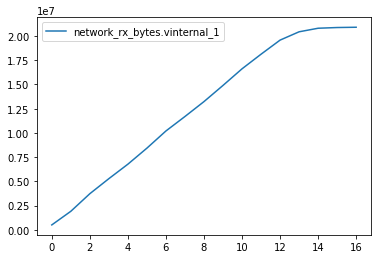

In [64]:
networkcumsumdf = metrics[["bins","network_rx_bytes.vinternal_1"]].groupby("bins").sum().cumsum().reset_index()
networkcumsumdf.plot()

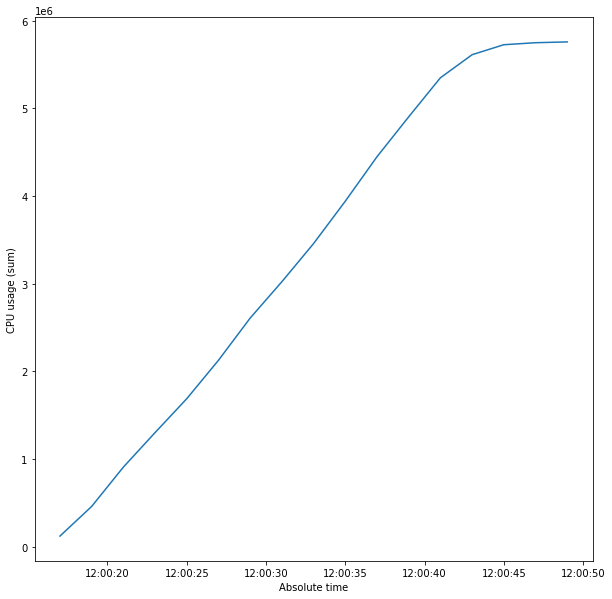

In [59]:
cpucumsumdf = cpusumdf[["bins","cpu_sum"]].groupby("bins").sum().cumsum().reset_index()

fig, ax = pyplot.subplots(figsize=(10,10))
pyplot.plot(cpucumsumdf["bins"].apply(lambda x: x.left), cpucumsumdf["cpu_sum"]/2, label="CPU Usage")
pyplot.xlabel("Absolute time")
pyplot.ylabel("CPU usage (sum)")
fig.savefig('cpuusage_sum.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

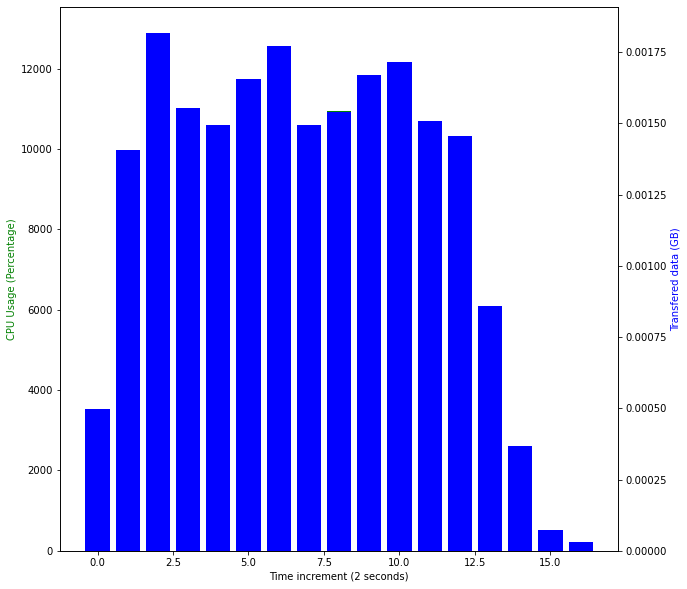

In [60]:
fig,ax = pyplot.subplots(figsize=(10,10))
ax.bar(cpusumdfpercent.index, cpusumdfpercent["cpu_sum"], color="green")
ax.set_ylabel("CPU Usage (Percentage)", color="green")
ax2 = ax.twinx()
ax2.bar(networksumdf.index, networksumdf["network_sum"]/pow(10,9), color="blue")
ax2.set_ylabel("Transfered data (GB)", color="blue")
ax.set_xlabel("Time increment (2 seconds)")
fig.savefig('cpuandnetwork.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

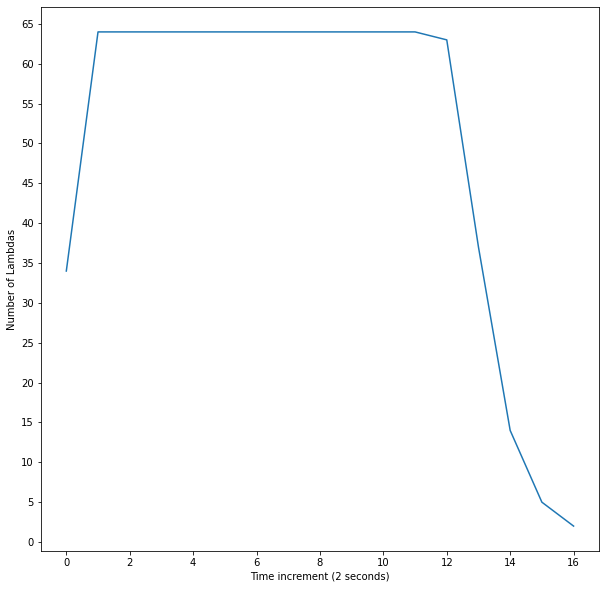

In [61]:
fig,ax = pyplot.subplots(figsize=(10,10))
ax.plot(cpusumdf["numlambdas"])
pyplot.yticks(list(range(0,70,5)))
pyplot.xlabel("Time increment (2 seconds)")
pyplot.ylabel("Number of Lambdas")
fig.savefig('numlambdas.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

Text(0, 0.5, 'CPU Usage (Percentage)')

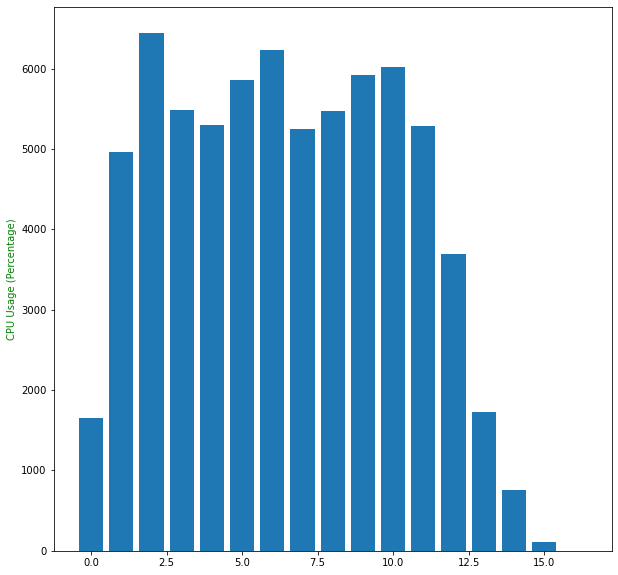

In [63]:
fig,ax = pyplot.subplots(figsize=(10,10))
ax.bar(cpusumdfpercent.index, cpusumdfpercent["cpu_sum"]/2)
ax.set_ylabel("CPU Usage (Percentage)", color="green")
